# IQ Data Analysis in Octave
This notebook demonstrates how to process raw I/Q samples:
- Load binary data from a `.dat` file
- Compute and visualize the Power Spectral Density (PSD)
- Inspect time-domain samples
- Plot amplitude histograms
- Save cleaned data for later use

Before running any code, specify your sampling rate and file path in the cells below

*Click regularly on the "save to browser storage button" (next to the download button) to not lose your progress.*

## 1. Set Sampling Frequency
Replace the blank assignment with your sampling rate in Hz.

In [1]:
% Sampling frequency (Hz)
fs = 1575.42e6;  % ← Enter sampling frequency, e.g. 1.000e6 for 1 MHz

## 2. Set Data File Path
Provide the relative or absolute path to your I/Q `.dat` file.

In [2]:
% Path to I/Q data file
data_file = 'GNSS_IQ_5sec.dat';  % ← Enter filename, e.g. 'test1.dat'

## 3. Load and Format I/Q Samples
Read the binary file, handle interleaved I/Q channels, and remove initial transients.

In [3]:
% === Fixed Parameters ===
fi = 0;                   % Intermediate frequency (Hz)
IsComplex = true;         % True if data is I/Q
Is8Bits = false;          % 8-bit integer format
Is16Bits = false;         % 16-bit integer format
Is32BitsFloat = true;     % 32-bit float format
secondOfData = 1;         % Seconds of data to read
fl1 = 1575.42e6;          % Center frequency (Hz) for labels
% ========================

% Read binary samples
[fid, errmsg] = fopen(data_file, 'rb');     % binary read

if fid == -1
    fprintf(2, '❌  Unable to open "%s": %s\n', data_file, errmsg);
    return              % Abort this cell early
end
if IsComplex
    if Is16Bits
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'int16');
    elseif Is8Bits
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'int8');
    else
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'float32');
    end
    data = raw(1:2:end) + 1i*raw(2:2:end);
else
    if Is16Bits
        [data, ~] = fread(fid, secondOfData*fs, 'int16');
    elseif Is8Bits
        [data, ~] = fread(fid, secondOfData*fs, 'int8');
    else
        [data, ~] = fread(fid, secondOfData*fs, 'float32');
    end
end
fclose(fid);

% Remove initial transient samples
if length(data) > 1e6
    data(1:1e6) = [];
end

## 4. Power Spectral Density
Use Welch's method to estimate PSD and plot it. Frequency axis is in MHz.

➡️  [PSD]  Starting Welch PSD estimate …
   ✓  Loaded Octave-Forge package: signal
   ✓  PSD computed with pwelch()


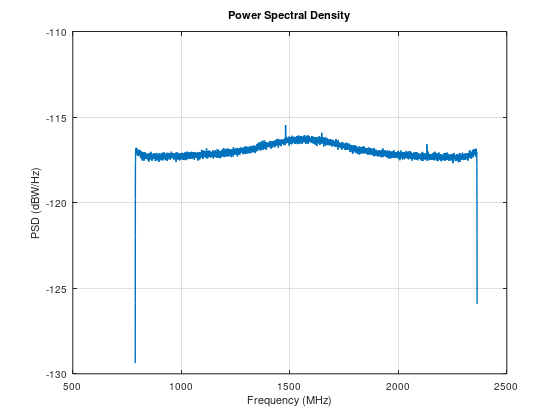

✅  [PSD]  Finished and plotted.


In [4]:
disp("➡️  [PSD]  Starting Welch PSD estimate …");

% ------------------------------------------------------------
% 1. Make sure the Octave-Forge “signal” package is available
% ------------------------------------------------------------
has_signal = false;
try
    % does "signal" appear in the installed-package list?
    pkgs = pkg("list");
    for k = 1 : numel(pkgs)
        if strcmp(pkgs{k}.name, "signal")
            has_signal = true;
            break
        end
    end
catch
    % pkg() itself not found (rare)
end

if has_signal
    try
        pkg load signal
        disp("   ✓  Loaded Octave-Forge package: signal");
    catch ME
        has_signal = false;
        fprintf(2,"   ⚠️  Could not load 'signal' package (%s). Falling back to naive PSD.\n", ME.message);
    end
else
    fprintf(2,"   ⚠️  Package 'signal' not installed. Falling back to naive PSD.\n");
end

% ------------------------------------------------------------
% 2. Compute PSD
% ------------------------------------------------------------
if has_signal
    [pw, f] = pwelch(data, [], [], [], fs);    % Welch method
    disp("   ✓  PSD computed with pwelch()");
else
    % --- simple rectangular window periodogram as a fallback ---
    Nfft  = 4096;
    win   = hanning(Nfft);                     % a little windowing to reduce leakage
    S     = fftshift( fft( data(1:Nfft) .* win.' , Nfft ) );
    pw    = (abs(S).^2) / (fs * sum(win.^2));
    f     = linspace(-fs/2, fs/2, Nfft);
    disp("   ✓  PSD computed with naive FFT method");
end

% ------------------------------------------------------------
% 3. Plot
% ------------------------------------------------------------
figure;
if IsComplex
    plot((f + fl1 - fs/2)/1e6, 10*log10(pw), 'LineWidth', 1);
else
    plot(f/1e6,          10*log10(pw), 'LineWidth', 1);
end
grid on;
xlabel('Frequency (MHz)');
ylabel('PSD (dBW/Hz)');
title('Power Spectral Density');

disp("✅  [PSD]  Finished and plotted.");

## 5. Time-Domain View
Visualize the first 100,000 samples of the real and imaginary parts.

➡️  [TD]  Plotting real & imaginary parts …
   ✓  Using first 100000 samples for the snapshot.


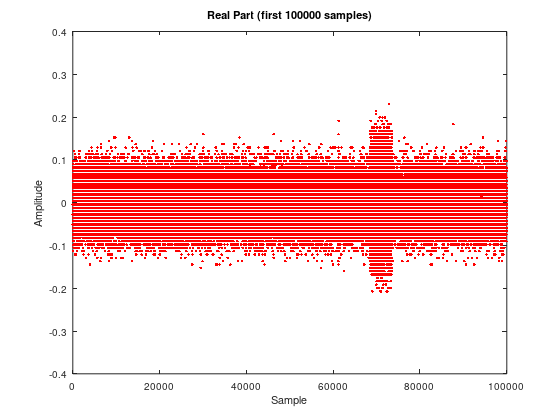

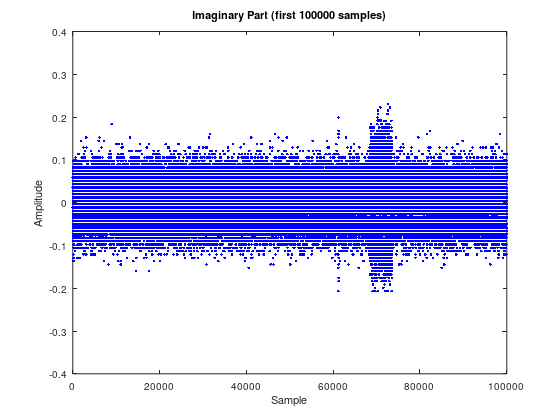

✅  [TD]  Finished plotting time-domain snapshots.


In [5]:
disp("➡️  [TD]  Plotting real & imaginary parts …");

% ------------------------------------------------------------
% 1. Decide how many samples we can safely show
% ------------------------------------------------------------
if numel(data) < 1e5
    nplot = numel(data);
    fprintf(2, "   ⚠️  Only %d samples available – plotting all of them.\n", nplot);
else
    nplot = 1e5;
    fprintf("   ✓  Using first %d samples for the snapshot.\n", nplot);
end

% ------------------------------------------------------------
% 2. Real component
% ------------------------------------------------------------
figure;
plot(real(data(1:nplot)), 'r.');
xlabel('Sample');  ylabel('Amplitude');
title(sprintf('Real Part (first %d samples)', nplot));

% ------------------------------------------------------------
% 3. Imaginary component
% ------------------------------------------------------------
figure;
plot(imag(data(1:nplot)), 'b.');
xlabel('Sample');  ylabel('Amplitude');
title(sprintf('Imaginary Part (first %d samples)', nplot));

disp("✅  [TD]  Finished plotting time-domain snapshots.");

## 6. Histogram of Real Component
Plot the amplitude distribution to check for clipping or quantization.

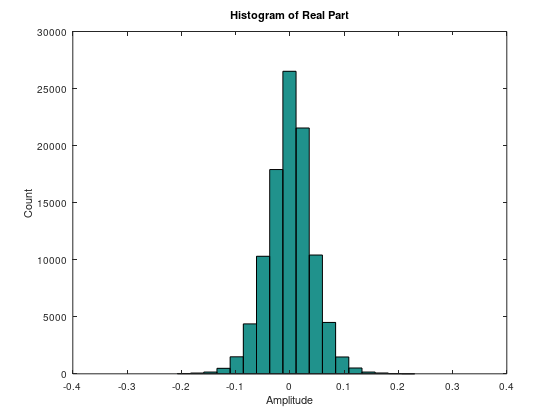

In [6]:
figure;
hist(real(data(1:1e5)), 18);
xlabel('Amplitude');
ylabel('Count');
title('Histogram of Real Part');

## 7. Save Processed Data
Store the cleaned complex samples for later analysis.

In [10]:
% Save to MAT-file
save('IQ_samples.mat', 'data');
disp('✅ Data saved to IQ_samples.mat');
disp('✅ Check in the left sidebar, you should find the .mat file there');
disp('⬅️ Proceed to the next notebook and click ');

✅ Data saved to IQ_samples.mat
✅ Check in the left sidebar, you should find the .mat file there
✅ Data saved to IQ_samples.mat
